In [242]:
pwd

'/Users/aidasaglinskas/Desktop/BC-FacExpr-1.2-fMRI-mainExp'

In [243]:
from matplotlib import pyplot as plt
from PIL import Image, ImageEnhance,ImageStat
import skvideo
import skvideo.io
import numpy as np
import os
from tqdm import tqdm

In [244]:
def load_video(fn):
    videodata = skvideo.io.vread(fn)
    return videodata

In [250]:
files = [os.path.join('./stimuli_cropped_normed_cb/',file) for file in os.listdir('./stimuli_cropped_normed_cb/') if file.endswith('.mp4')]
files.sort()
files[0:5]

['./stimuli_cropped_normed_cb/id1d1.mp4',
 './stimuli_cropped_normed_cb/id1d2.mp4',
 './stimuli_cropped_normed_cb/id1f1.mp4',
 './stimuli_cropped_normed_cb/id1f2.mp4',
 './stimuli_cropped_normed_cb/id1h1.mp4']

In [251]:
len(files)

70

In [252]:
hist_brightness = []
hist_contrast = []
hist_r = []
hist_g = []
hist_b = []
for file in tqdm(files):
    vid = load_video(file)
    hist_brightness.append(  vid[0,:,:,:].mean()  )
    hist_contrast.append(  vid[0,:,:,:].mean(axis=-1).std() )
    
    hist_r.append( vid[:,:,:,0].mean() )
    hist_g.append( vid[:,:,:,1].mean() )
    hist_b.append( vid[:,:,:,2].mean() )

100%|███████████████████████████████████████████| 70/70 [00:11<00:00,  5.84it/s]


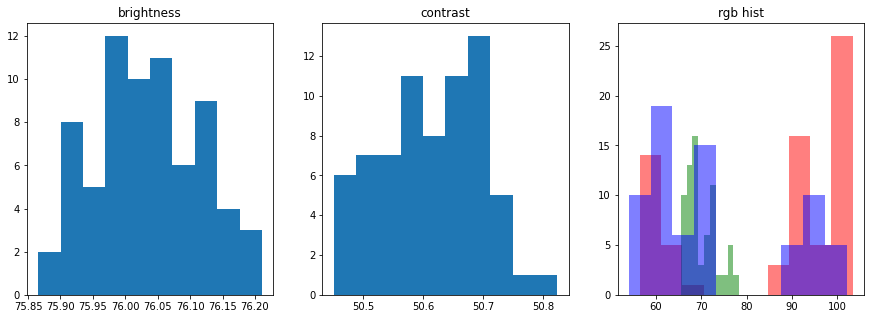

In [253]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(hist_brightness);
plt.title('brightness');
plt.subplot(1,3,2)
plt.hist(hist_contrast);
plt.title('contrast');
plt.subplot(1,3,3)
plt.hist(hist_r,color='r',alpha=.5);
plt.hist(hist_g,color='g',alpha=.5);
plt.hist(hist_b,color='b',alpha=.5);
plt.title('rgb hist');

In [254]:
brightness_target = np.array(hist_brightness).mean()
brightness_target.round(3)

76.036

In [255]:
contrast_target = np.array(hist_contrast).mean()
contrast_target.round(3)

50.614

In [256]:
target_r = np.array(hist_r).mean().round(3)
target_g = np.array(hist_g).mean().round(3)
target_b = np.array(hist_b).mean().round(3)
(target_r,target_g,target_b)

(86.278, 70.028, 72.093)

In [257]:
target_r = np.array(hist_r).mean().round(3)
target_g = np.array(hist_g).mean().round(3)
target_b = np.array(hist_b).mean().round(3)

In [259]:
np.array(hist_r).sum()

6039.4752655480415

In [260]:
l = 50
face_squares = np.array([load_video(files[i])[0,:,:,:][256-l:256+l,256-l:256+l,:] for i in tqdm(range(len(files))) ])

100%|███████████████████████████████████████████| 70/70 [00:18<00:00,  3.71it/s]


In [274]:
face_squares.shape

(70, 100, 100, 3)

In [275]:
ctargets = face_squares[0:10].mean(axis=0).mean(axis=0).mean(axis=0)
ctargets

array([110.44533, 114.32711, 118.32714])

In [276]:
# def brighten_video(videodata,factor=1):
#     return np.array([np.array(ImageEnhance.Brightness(Image.fromarray(videodata[frame,:,:,:])).enhance(factor)) for frame in range(videodata.shape[0])])

In [263]:
# def contrast_video(videodata,factor=1):
#     return np.array([np.array(ImageEnhance.Contrast(Image.fromarray(videodata[frame,:,:,:])).enhance(factor)) for frame in range(videodata.shape[0])])

In [264]:
def save_video(videodata,ofn='outvideo.mp4'):
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})

In [265]:
def tint_video(videodata,ctargets,bw=False): 
    #ctargets = (target_r,target_g,target_b)
    videodata_copy = videodata.copy()
    videodata_copy = videodata_copy.astype(np.float16) # otherwise 255 overflows and you get patches
    for frame in range(videodata.shape[0]):
        for channel in range(3):
            if bw==False:
                c_diff = ctargets[channel]-videodata_copy[frame,:,:,channel].mean()
                videodata_copy[frame,:,:,channel] = videodata_copy[frame,:,:,channel]+c_diff
                videodata_copy[videodata_copy>255]=255
                videodata_copy[videodata_copy<0]=0
                
            else:
                bw_frame = np.array(Image.fromarray(videodata_copy[frame,:,:,:]).convert('L'))
                videodata_copy[frame,:,:,channel] = bw_frame
                
    videodata_copy = videodata_copy.astype(np.uint8)
    return videodata_copy

In [266]:
def tint_video_face_square(videodata,face_square,ctargets,bw=False): 
    
    videodata_copy = videodata.copy()
    videodata_copy = videodata_copy.astype(np.float64) # otherwise 255 overflows and you get patches
    for frame in range(videodata.shape[0]):
        for channel in range(3):
            if bw==False:
                #c_diff = ctargets[channel]-videodata_copy[frame,:,:,channel].mean()
                #c_diff = ctargets[channel] - face_square.mean(axis=0).mean(axis=0)[channel]
                #videodata_copy[frame,:,:,channel] = videodata_copy[frame,:,:,channel]+c_diff
                
                c_diff = face_square.mean(axis=0).mean(axis=0)[channel] - ctargets[channel]
                videodata_copy[frame,:,:,channel] = videodata_copy[frame,:,:,channel] - c_diff
                
                videodata_copy[videodata_copy>255]=255 # Overflow hax
                videodata_copy[videodata_copy<0]=0 # Underflow hax
                
            else:
                bw_frame = np.array(Image.fromarray(videodata_copy[frame,:,:,:]).convert('L'))
                videodata_copy[frame,:,:,channel] = bw_frame
                
    videodata_copy = videodata_copy.astype(np.uint8)
    return videodata_copy

In [267]:
def make_ref(ctargets):
    ref = np.ones((10,10,3))
    for i in range(3):
        ref[:,:,i] = ref[:,:,i] * ctargets[i]
    return ref.astype(np.uint8)

In [268]:
def get_face(framem,l=50):
    return frame[256-l:256+l,256-l:256+l,:]

In [269]:
def get_mean_rbg(frame):
    return frame.mean(axis=0).mean(axis=0)

In [157]:
get_mean_rbg(face_square)

array([156.7486, 150.5824, 152.4498])

In [161]:
diff = get_mean_rbg(face_square)-ctargets
diff

array([  3.2287,  81.5065, 104.7373])

In [163]:
face_square_copy[:,:,2]-diff[2]

array([[109.2627, 106.2627, 105.2627, ..., 116.2627, 119.2627, 123.2627],
       [102.2627,  99.2627,  98.2627, ..., 117.2627, 123.2627, 130.2627],
       [102.2627, 102.2627, 100.2627, ..., 101.2627, 114.2627, 117.2627],
       ...,
       [-29.7373, -28.7373, -25.7373, ..., -69.7373, -67.7373, -67.7373],
       [-33.7373, -33.7373, -27.7373, ..., -69.7373, -67.7373, -67.7373],
       [-33.7373, -33.7373, -29.7373, ..., -68.7373, -67.7373, -67.7373]])

In [177]:
face_square_copy = face_square.astype(np.float64)
for i in range(3):
    face_square_copy[:,:,i] = face_square_copy[:,:,i]-diff[i]
    face_square_copy[face_square_copy<0]=0
    face_square_copy[face_square_copy>255]=255

face_square_copy= face_square_copy.astype(np.uint8)

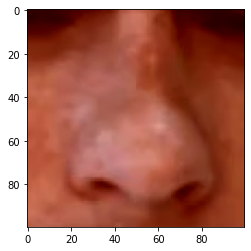

In [270]:
plt.imshow(face_square_copy)

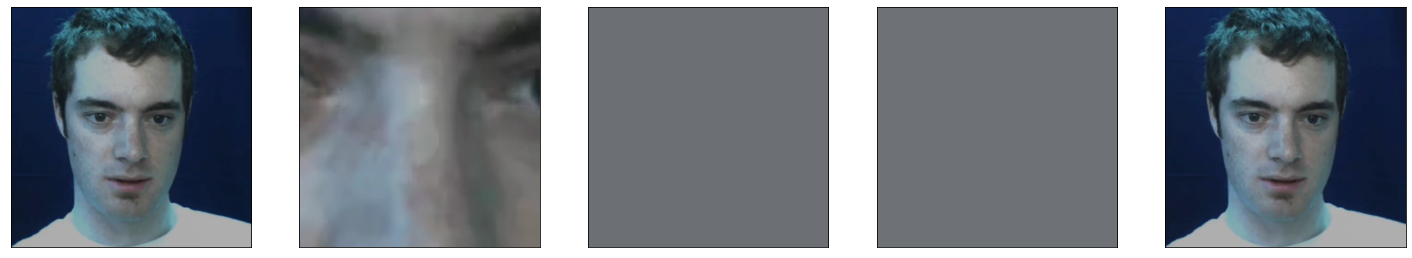

In [277]:
f = 0
fn = files[f]
videodata = load_video(fn)
frame = videodata[0,:,:,:]
face_square = get_face(frame)

diff = get_mean_rbg(face_square)-ctargets

frame_copy = frame.astype(np.float64)
for i in range(3):
    frame_copy[:,:,i] = frame_copy[:,:,i]-diff[i]
    frame_copy[frame_copy<0]=0
    frame_copy[frame_copy>255]=255

frame_copy = frame_copy.astype(np.uint8)


plt.figure(figsize=(25,5))
plt.subplot(1,5,1);plt.imshow(frame);plt.xticks([]);plt.yticks([]);
plt.subplot(1,5,2);plt.imshow(face_square);plt.xticks([]);plt.yticks([]);
plt.subplot(1,5,3);plt.imshow(make_ref(face_square.mean(axis=0).mean(axis=0)));plt.xticks([]);plt.yticks([]);
plt.subplot(1,5,4);plt.imshow(make_ref(ctargets));plt.xticks([]);plt.yticks([]);
plt.subplot(1,5,5);plt.imshow(frame_copy);plt.xticks([]);plt.yticks([]);

In [284]:
fn

'./stimuli_cropped_normed_cb/id7d2.mp4'

  0%|                                                     | 0/7 [00:00<?, ?it/s]

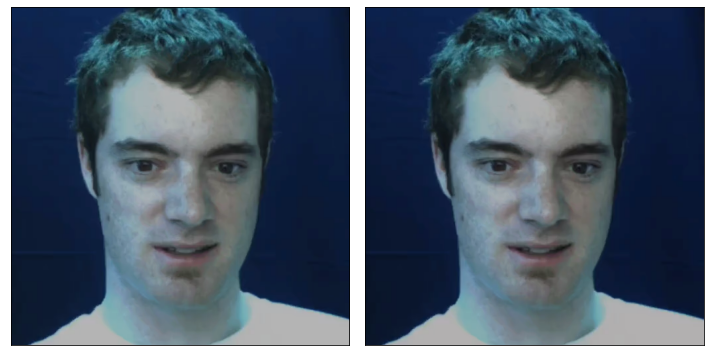

 14%|██████▍                                      | 1/7 [00:22<02:15, 22.50s/it]

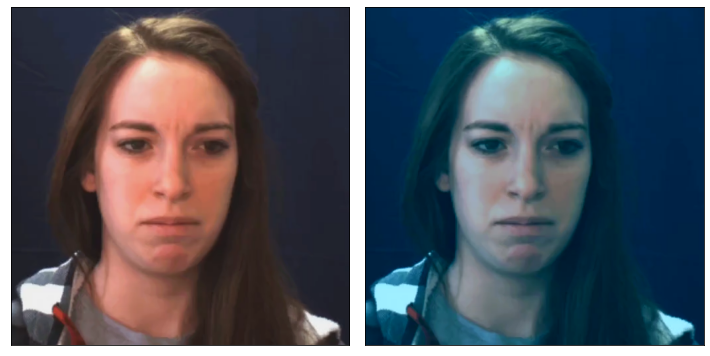

 29%|████████████▊                                | 2/7 [00:42<01:46, 21.27s/it]

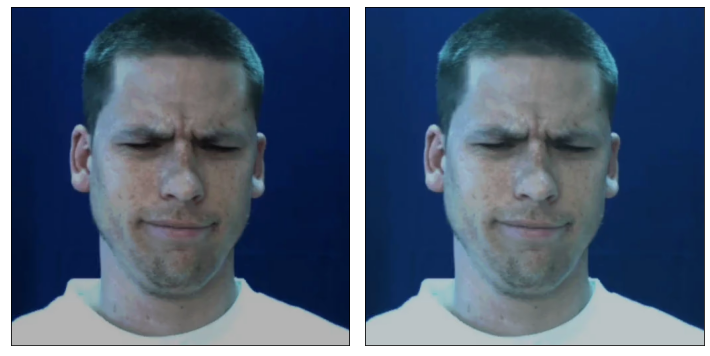

 43%|███████████████████▎                         | 3/7 [01:02<01:21, 20.47s/it]

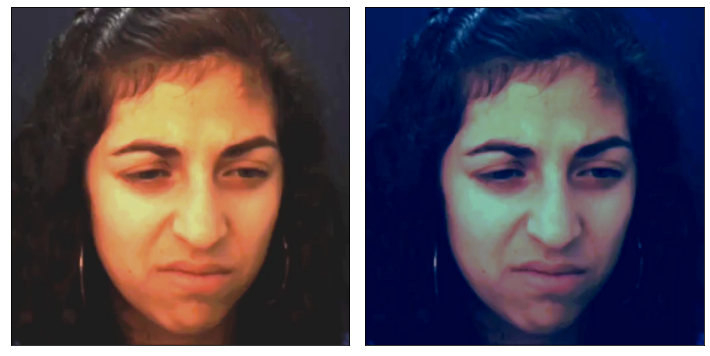

 57%|█████████████████████████▋                   | 4/7 [01:23<01:02, 20.76s/it]

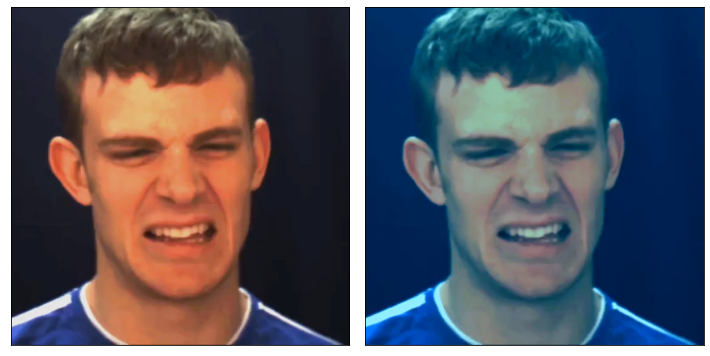

 71%|████████████████████████████████▏            | 5/7 [01:44<00:41, 20.88s/it]

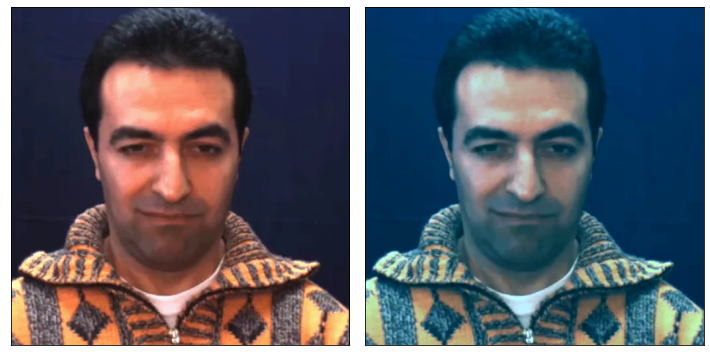

 86%|██████████████████████████████████████▌      | 6/7 [02:06<00:21, 21.19s/it]

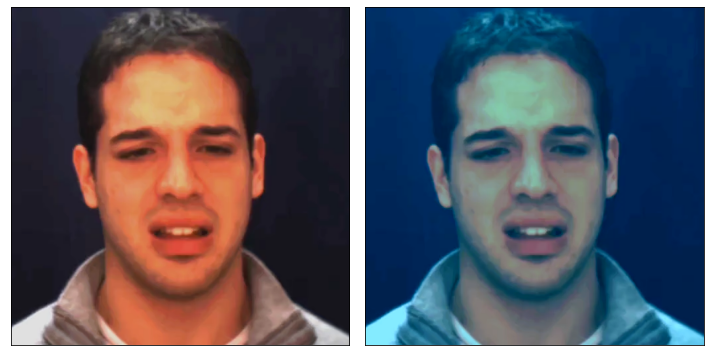

100%|█████████████████████████████████████████████| 7/7 [02:27<00:00, 21.05s/it]


In [278]:
# NORMALIZE TO TARGET VALUES
#for f in tqdm(range(len(files))):
for f in tqdm(  np.arange(1,71,10)  ):
    fn = files[f]
    videodata = load_video(fn)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(videodata[0,:,:,:]);plt.xticks([]);plt.yticks([]);
    
    videodata = tint_video_face_square(videodata,face_squares[f,:,:,:],ctargets)
    
    plt.subplot(1,2,2)
    plt.imshow(videodata[0,:,:,:]);plt.xticks([]);plt.yticks([]);
    plt.tight_layout()
    plt.show()
    
    save_video(videodata,ofn=fn.replace('./stimuli_cropped/','./stimuli_cropped_normed_cb_tint/'))

In [283]:
files = [os.path.join('./stimuli_cropped_normed_cb_tint/',file) for file in os.listdir('./stimuli_cropped_normed_cb_tint/') if file.endswith('.mp4')]
files.sort()
files[0:5]

[]

In [282]:
[print(get_mean_rbg(get_face(load_video(file)[0,:,:,:]))) for file in files];

100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]


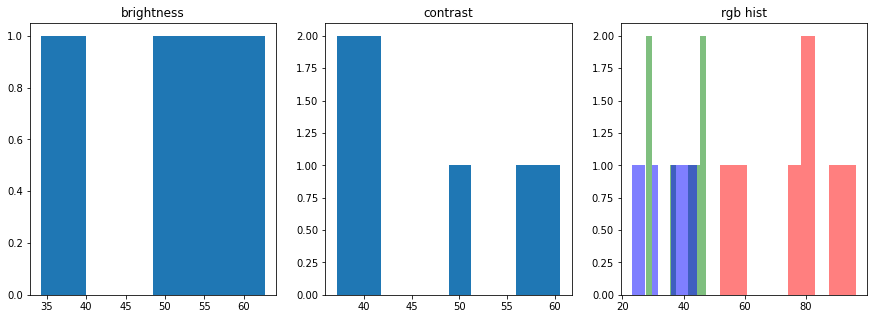

In [210]:
hist_brightness = []
hist_contrast = []

hist_r = []
hist_g = []
hist_b = []


for file in tqdm(files):
    vid = load_video(file)
    hist_brightness.append(  vid[0,:,:,:].mean()  )
    hist_contrast.append(  vid[0,:,:,:].mean(axis=-1).std() )
            
    hist_r.append( vid[0,:,:,0].mean() )
    hist_g.append( vid[0,:,:,1].mean() )
    hist_b.append( vid[0,:,:,2].mean() )

    
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(hist_brightness);
plt.title('brightness');
plt.subplot(1,3,2)
plt.hist(hist_contrast);
plt.title('contrast');
plt.subplot(1,3,3)
plt.hist(hist_r,color='r',alpha=.5);
plt.hist(hist_g,color='g',alpha=.5);
plt.hist(hist_b,color='b',alpha=.5);
plt.title('rgb hist');

In [123]:
np.array(hist_brightness).mean().round(3)

125.516

In [125]:
np.array(hist_contrast).mean().round(3)

28.657

In [121]:
[np.array(i).mean().round(3) for i in [hist_r,hist_g,hist_b]]

[124.844, 131.399, 120.307]